In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Seurat)
library(harmony)
library(SPOTlight)
library(SingleCellExperiment)
library(SpatialExperiment)
library(scater)
library(scran)
library(ggplot2)
library(patchwork)
library(ggpubr)
library(dplyr)
library(Matrix)
library(Hmisc)
library(RColorBrewer)
library(ggrepel)
library(gtools)
})
set.seed(123)

In [2]:
# load the data
sample <- Load10X_Spatial("./matrix", filename = "filtered_feature_bc_matrix.h5")

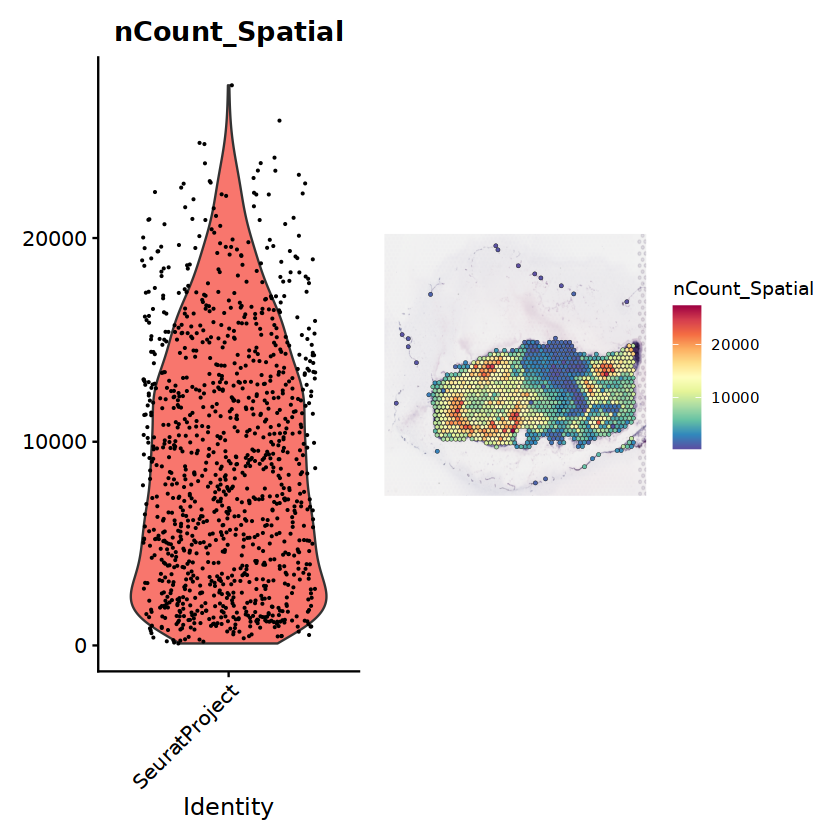

In [3]:
# quality control and counts across spots
plot1 <- VlnPlot(sample, features = "nCount_Spatial", pt.size = 0.1) + NoLegend()
plot2 <- SpatialFeaturePlot(sample, features = "nCount_Spatial") + theme(legend.position = "right")
wrap_plots(plot1, plot2)

In [4]:
# normalize the data using sctransform
sample <- SCTransform(sample, assay = "Spatial", verbose = FALSE)

In [5]:
# dimensionality reduction and clustering
suppressWarnings({
sample <- RunPCA(sample, assay = "SCT", verbose = FALSE)
sample <- FindNeighbors(sample, reduction = "pca", dims = 1:30)
sample <- FindClusters(sample, verbose = FALSE)
sample <- RunUMAP(sample, reduction = "pca", dims = 1:30, verbose = FALSE)
})

Computing nearest neighbor graph

Computing SNN



In [6]:
# save the spatial data
saveRDS(sample, file = "sample_human_EHT_spatial.rds")

In [7]:
# deconvolution not good
# # load the single-cell reference data
# sample_agm <- readRDS("../1_EHT_RNA_Preprocessing/sample_human_agm_annotated.rds")
# sample_eht <- readRDS("../1_EHT_RNA_Preprocessing/sample_human_annotated.rds")

# sample_agm_raw <- sample_agm

# sample_agm <- sample_agm_raw

# # refine the celltype annotation for single-cell reference data
# sample_agm$celltype <- as.character(sample_agm$celltype)
# sample_agm@meta.data[colnames(subset(sample_eht, idents = "AEC")), "celltype"] <- "AEC"
# sample_agm@meta.data[colnames(subset(sample_eht, idents = "pre-HEC")), "celltype"] <- "pre-HEC"
# sample_agm@meta.data[sample_agm$celltype == "Endo", "celltype"] <- "VEC"
# DimPlot(sample_agm, group.by = "celltype", label = TRUE) + NoLegend()

# # remove VECs in cluster 9
# sample_agm <- subset(sample_agm, cells = rownames(sample_agm@meta.data[sample_agm$seurat_clusters == 9 & sample_agm$celltype == "VEC", ]), invert = T)

# Idents(sample_agm) <- sample_agm$celltype

# celltype_marker_genes <- FindAllMarkers(sample_agm, assay = "RNA", test.use = "MAST", only.pos = TRUE, min.diff.pct = 0.1, verbose = FALSE)

# sample_spatial_count <- as.data.frame(sample@assays$Spatial@counts)

# res <- SPOTlight(
#     x = sample_agm,
#     y = extract_counts_test(sample, "Spatial", "counts"),
#     groups = as.character(sample_agm$celltype),
#     mgs = celltype_marker_genes,
#     hvg = VariableFeatures(sample_agm),
#     weight_id = "p_val_adj",
#     group_id = "cluster",
#     gene_id = "gene",
#     assay = "Spatial")

# saveRDS(res, file = "res_SPOTlight.rds")

# plotTopicProfiles(
#     x = res$NMF,
#     y = sample_agm$celltype,
#     facet = FALSE,
#     min_prop = 0.01,
#     ncol = 1) +
#     theme(aspect.ratio = 1)

# plotCorrelationMatrix(res$mat)

# plotInteractions(res$mat, which = "heatmap", metric = "jaccard")

# mat <- res$mat
# ct <- colnames(mat)
# mat[mat < 0.1] <- 0

# plotSpatialScatterpie(
#     x = sample,
#     y = mat,
#     cell_types = colnames(mat),
#     img = FALSE,
#     scatterpie_alpha = 1,
#     pie_scale = 0.4)

In [8]:
# plot EHT markers
DefaultAssay(sample) <- "SCT"
eht_genes <- c("GJA5","TMEM100","RUNX1","MYB")
for(gene in eht_genes){
    SpatialFeaturePlot(sample, features = gene, alpha = c(0.4, 0.6), stroke = NA, max.cutoff = 1.8) + scale_fill_gradientn(colours = c("grey90", "red3")) + scale_color_continuous()
    ggsave(paste("./marker/", gene, "_ST.pdf", sep = ""), width = 5, height = 5)
}

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [9]:
# plot hypoxia genes
hypoxia_genes <- c("HIF1A","EPAS1","HIF3A","CXCL12","NOTCH1","VEGFC","GATA6","MMP2","DNMT1","UHRF1")
for(gene in hypoxia_genes){
    SpatialFeaturePlot(sample, features = gene, alpha = c(0.4, 0.6), stroke = NA) + scale_fill_gradientn(colours = c("grey90", "red3")) + scale_color_continuous()
    ggsave(paste("./marker/", gene, "_ST.pdf", sep = ""), width = 5, height = 5)
}

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale

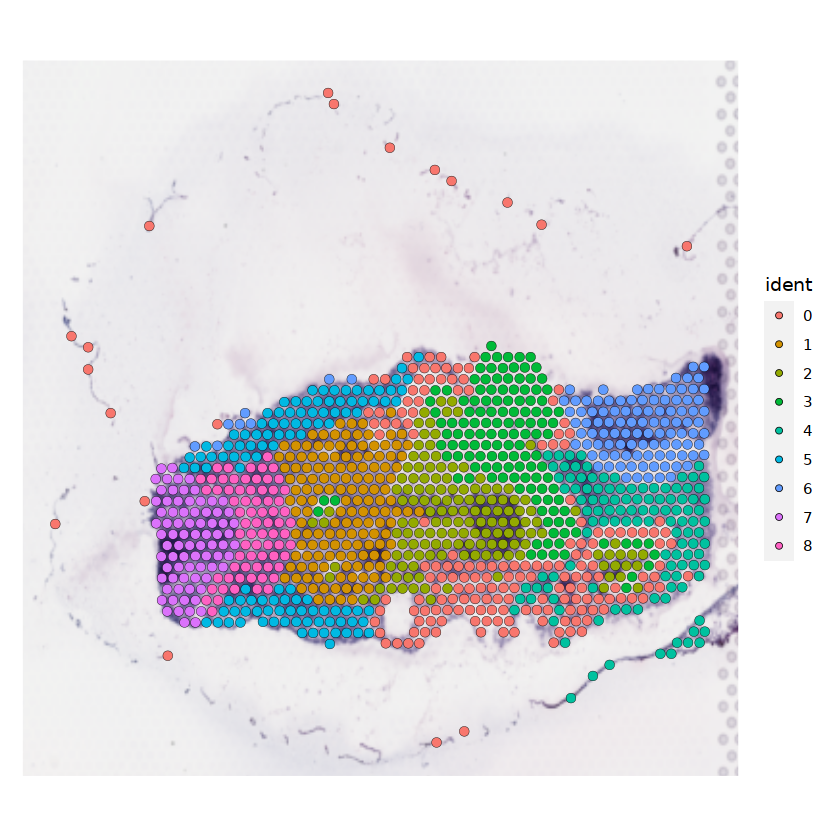

In [10]:
# plot spatial umap by clusters
SpatialDimPlot(sample, label = F, label.size = 3)

In [11]:
# integrate the EHT and TE sample
count_matrix <- read.csv("./matrix/AGM_sample7_human_TE.csv", row.names = 1, check.names = F)
sample_TE <- CreateSeuratObject(count_matrix, project = "sample7")
sample_TE <- subset(sample_TE, cells = intersect(colnames(sample_TE), colnames(sample)))
sample_gene <- subset(sample, cells = intersect(colnames(sample_TE), colnames(sample)))

count_matrix_all <- rbind(sample_gene@assays$Spatial@counts, sample_TE@assays$RNA@counts)
sample_TE_Gene <- CreateSeuratObject(count_matrix_all, meta.data = sample_gene@meta.data)
sample_TE_Gene

sample_ST <- sample_gene
sample_ST@assays$Spatial@counts <- count_matrix_all

count_TE_sum <- data.frame(TE <- rownames(count_matrix), count = rowSums(count_matrix))
count_TE_sum[order(count_TE_sum$count, decreasing = T), ]

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
37798 features across 1090 samples within 1 assay 
Active assay: RNA (37798 features, 0 variable features)

,TE....rownames.count_matrix.,count
,<chr>,<dbl>
AluSx1.Alu.SINE,AluSx1.Alu.SINE,25176
AluSz.Alu.SINE,AluSz.Alu.SINE,24455
MIRb.MIR.SINE,MIRb.MIR.SINE,24360
AluJb.Alu.SINE,AluJb.Alu.SINE,24251
AluSx.Alu.SINE,AluSx.Alu.SINE,22769
AluY.Alu.SINE,AluY.Alu.SINE,21820
L2a.L2.LINE,L2a.L2.LINE,21811
MIR.MIR.SINE,MIR.MIR.SINE,17892
AluJo.Alu.SINE,AluJo.Alu.SINE,17686


In [12]:
# normalize the data using sctransform
sample_ST <- SCTransform(sample_ST, assay = "Spatial", verbose = FALSE)
saveRDS(sample_ST, file = "sample_agm_spatial_TE.rds")

In [13]:
# load spatial sample with TEs
sample_ST <- readRDS("sample_agm_spatial_TE.rds")

In [15]:
# score modules on the spatial sample
te_module_hg38 <- read.csv("meta/te_module_hg38.csv", row.names = 1)
te_hme5_good <- rownames(subset(te_module_hg38, kME >= 0.5))

te_silencers <- read.csv("meta/TE_silencers_all_average_expression_human.csv", row.names = 1)
te_silencers <- rownames(subset(te_silencers, Down == TRUE))

te_hme5_list <- list(TEs_HME5 = te_hme5_good, TE_Silencers = te_silencers)

sample_score <- sample_ST
sample_score <- AddModuleScore(sample_score, features = te_hme5_list, assay = "SCT")
colnames(sample_score@meta.data)[8:9] <- c("TEs_HME5", "TEs_Silencers")

Warning message:
“The following features are not present in the object: ZIM2, ZNF320, ZNF556, ZNF560, ZNF573, ZNF729, GTSF1, not searching for symbol synonyms”


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


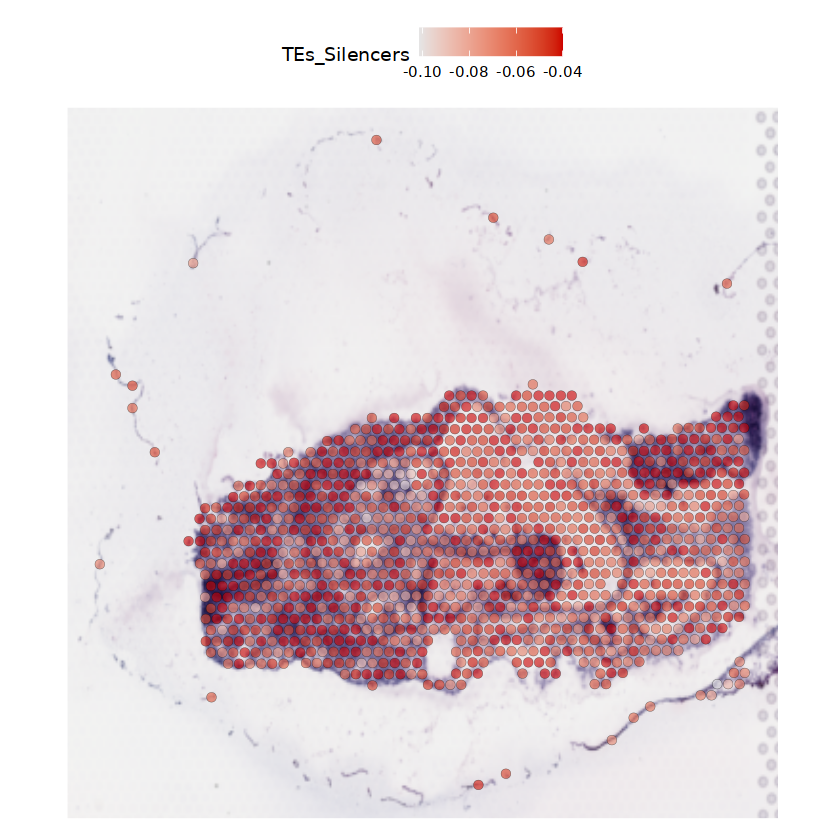

In [16]:
# plot TE silencers score
SpatialFeaturePlot(sample_score, features = c("TEs_Silencers"), alpha = c(0.6, 0.6), max.cutoff = -0.04) + scale_fill_gradientn(colours = c("grey90", "red3"))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


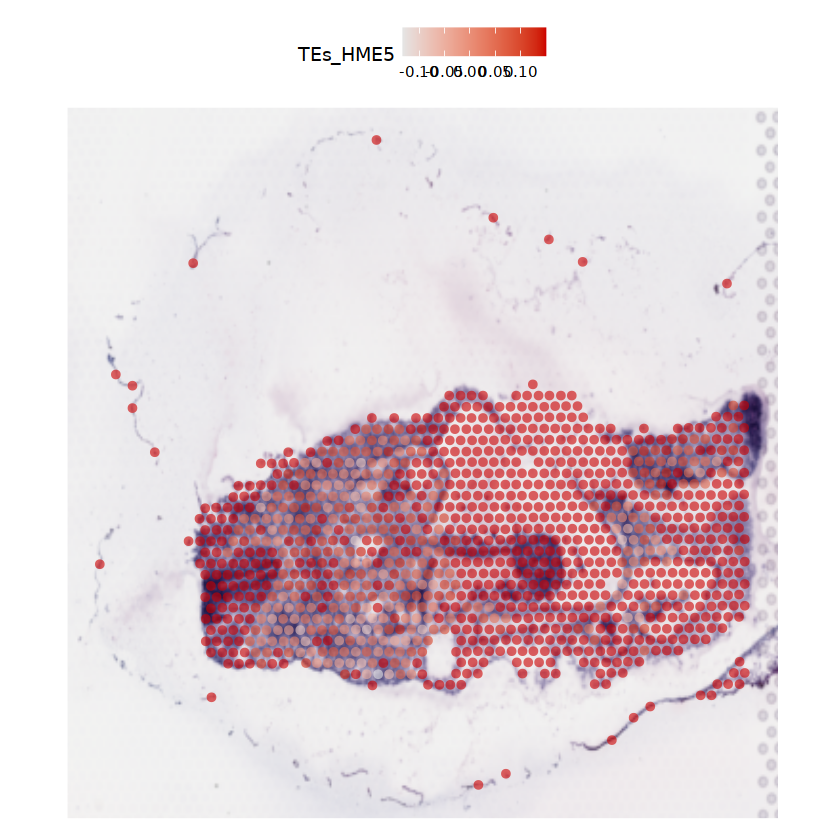

In [17]:
# plot TE module score
SpatialFeaturePlot(sample_score, features = c("TEs_HME5"), alpha = c(0.6, 0.6), max.cutoff = 0.15, stroke = NA) + scale_fill_gradientn(colours = c("grey90", "red3"))

In [18]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gtools_3.9.4                ggrepel_0.9.3              
 [3] RColorBrewer_1.1-3          Hmisc_5.0-1                
 [5] Matrix_1.5-4                dplyr_1.1.1                
 [7] ggpubr_0.6.0                patchwork_1.1.2            
 [9] scran_1.26.2                scater_1.26.1              
[11] ggplot2_3.4.2               scuttle_1.8.4              
[13] SpatialExperiment_1.8.1     Sing